<a href="https://colab.research.google.com/github/oskar-furmanczuk/coronavirus-spark-PY/blob/master/coronavirus_spark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# By projekt był kompatybilny ze standardowym środowiskiem Google Colab niezbędny jest run poniższego bloku kodu
%%capture
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
!wget -q https://www-us.apache.org/dist/spark/spark-3.0.0-preview2/spark-3.0.0-preview2-bin-hadoop3.2.tgz
!tar -xvf spark-3.0.0-preview2-bin-hadoop3.2.tgz
!pip install -q findspark
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.0.0-preview2-bin-hadoop3.2"

In [0]:
import findspark
findspark.init()
from pyspark.sql import SparkSession
spark = SparkSession.builder.master("local[*]").getOrCreate()

In [0]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

In [4]:
url = "https://opendata.ecdc.europa.eu/covid19/casedistribution/csv"
df = pd.read_csv(url)
print("\nPRZED USUNIĘCIEM NIEPEŁNYCH WIERSZY\n")
df.info()
df.dropna(inplace=True)
print("\nPO USUNIĘCIU NIEPEŁNYCH WIERSZY\n")
df.info()


PRZED USUNIĘCIEM NIEPEŁNYCH WIERSZY

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 22801 entries, 0 to 22800
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dateRep                  22801 non-null  object 
 1   day                      22801 non-null  int64  
 2   month                    22801 non-null  int64  
 3   year                     22801 non-null  int64  
 4   cases                    22801 non-null  int64  
 5   deaths                   22801 non-null  int64  
 6   countriesAndTerritories  22801 non-null  object 
 7   geoId                    22712 non-null  object 
 8   countryterritoryCode     22473 non-null  object 
 9   popData2018              22455 non-null  float64
 10  continentExp             22801 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 1.9+ MB

PO USUNIĘCIU NIEPEŁNYCH WIERSZY

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22302

In [5]:
dataset = spark.createDataFrame(df)
dataset.show()

+----------+---+-----+----+-----+------+-----------------------+-----+--------------------+-----------+------------+
|   dateRep|day|month|year|cases|deaths|countriesAndTerritories|geoId|countryterritoryCode|popData2018|continentExp|
+----------+---+-----+----+-----+------+-----------------------+-----+--------------------+-----------+------------+
|11/06/2020| 11|    6|2020|  684|    21|            Afghanistan|   AF|                 AFG|3.7172386E7|        Asia|
|10/06/2020| 10|    6|2020|  542|    15|            Afghanistan|   AF|                 AFG|3.7172386E7|        Asia|
|09/06/2020|  9|    6|2020|  575|    12|            Afghanistan|   AF|                 AFG|3.7172386E7|        Asia|
|08/06/2020|  8|    6|2020|  791|    30|            Afghanistan|   AF|                 AFG|3.7172386E7|        Asia|
|07/06/2020|  7|    6|2020|  582|    18|            Afghanistan|   AF|                 AFG|3.7172386E7|        Asia|
|06/06/2020|  6|    6|2020|  915|     9|            Afghanistan|

In [6]:
dataset.printSchema()

root
 |-- dateRep: string (nullable = true)
 |-- day: long (nullable = true)
 |-- month: long (nullable = true)
 |-- year: long (nullable = true)
 |-- cases: long (nullable = true)
 |-- deaths: long (nullable = true)
 |-- countriesAndTerritories: string (nullable = true)
 |-- geoId: string (nullable = true)
 |-- countryterritoryCode: string (nullable = true)
 |-- popData2018: double (nullable = true)
 |-- continentExp: string (nullable = true)



In [7]:
import pyspark.sql.functions as F
dataset = dataset.withColumn("daily_cases_per_100k_inhabitants", dataset.cases * 100000/dataset.popData2018)
dataset = dataset.withColumn("daily_deaths_per_100k_inhabitants", dataset.deaths * 100000/dataset.popData2018)
dataset.show()
dataset.createOrReplaceTempView("dataset")

+----------+---+-----+----+-----+------+-----------------------+-----+--------------------+-----------+------------+--------------------------------+---------------------------------+
|   dateRep|day|month|year|cases|deaths|countriesAndTerritories|geoId|countryterritoryCode|popData2018|continentExp|daily_cases_per_100k_inhabitants|daily_deaths_per_100k_inhabitants|
+----------+---+-----+----+-----+------+-----------------------+-----+--------------------+-----------+------------+--------------------------------+---------------------------------+
|11/06/2020| 11|    6|2020|  684|    21|            Afghanistan|   AF|                 AFG|3.7172386E7|        Asia|              1.8400755872921366|              0.05649354873265332|
|10/06/2020| 10|    6|2020|  542|    15|            Afghanistan|   AF|                 AFG|3.7172386E7|        Asia|              1.4580715910999096|              0.04035253480903808|
|09/06/2020|  9|    6|2020|  575|    12|            Afghanistan|   AF|          

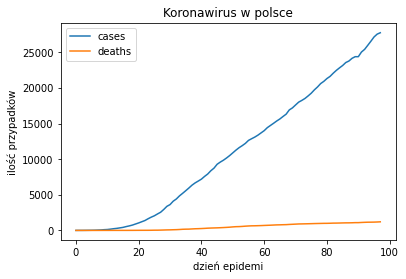

In [8]:
dataset_PL = dataset.filter(dataset.geoId=="PL")
dataset_PL = dataset_PL.orderBy(dataset_PL.year,dataset_PL.month, dataset_PL.day )
df_PL = dataset_PL.toPandas()
df_PL.cases.cumsum().plot(title = "Koronawirus w polsce", legend=True)
df_PL.deaths.cumsum().plot(legend=True)
plt.xlabel('dzień epidemi')
plt.ylabel('ilość przypadków')
plt.show()


In [9]:
tab1 = spark.sql(
    "SELECT countriesAndTerritories, sum(cases) as cases_per_country, sum(deaths) as deaths_per_country\
     FROM dataset \
     GROUP BY countriesAndTerritories \
     ORDER BY cases_per_country DESC" 
    )
tab1.createOrReplaceTempView("tab1")
tab1.show()

+-----------------------+-----------------+------------------+
|countriesAndTerritories|cases_per_country|deaths_per_country|
+-----------------------+-----------------+------------------+
|   United_States_of_...|          2000464|            112924|
|                 Brazil|           772416|             39680|
|                 Russia|           493657|              6358|
|         United_Kingdom|           290143|             41128|
|                  India|           286579|              8102|
|                  Spain|           242280|             27136|
|                  Italy|           235763|             34114|
|                   Peru|           208823|              5903|
|                Germany|           185416|              8755|
|                   Iran|           177938|              8506|
|                 Turkey|           173036|              4746|
|                 France|           155136|             29319|
|                  Chile|           148496|            

In [10]:
print("\nTABELA PRZEDSTAIWAJĄCA ILOŚĆ ZACHOROWAŃ PER KRAJ NA 1OO 000 MIESZKAŃCÓW\n")
tab2 = spark.sql(
    "SELECT DISTINCT dataset.countriesAndTerritories, dataset.geoId, (cases_per_country/dataset.popData2018 * 100000) AS cases_per_100k_inhabitants \
    FROM tab1 INNER JOIN dataset ON tab1.countriesAndTerritories = dataset.countriesAndTerritories \
    ORDER BY cases_per_100k_inhabitants DESC"
    )
tab2.show()

print("\nTABELA PRZEDSTAIWAJĄCA ILOŚĆ ZGONÓW PER KRAJ NA 1OO 000 MIESZKAŃCÓW\n")
tab3 = spark.sql(
    "SELECT DISTINCT dataset.countriesAndTerritories, dataset.geoId, (deaths_per_country/dataset.popData2018 * 100000) AS deaths_per_100k_inhabitants \
    FROM tab1 INNER JOIN dataset ON tab1.countriesAndTerritories = dataset.countriesAndTerritories \
    ORDER BY deaths_per_100k_inhabitants DESC"
    )
tab3.show()


TABELA PRZEDSTAIWAJĄCA ILOŚĆ ZACHOROWAŃ PER KRAJ NA 1OO 000 MIESZKAŃCÓW

+-----------------------+-----+--------------------------+
|countriesAndTerritories|geoId|cases_per_100k_inhabitants|
+-----------------------+-----+--------------------------+
|                  Qatar|   QA|        2645.7061693359797|
|             San_Marino|   SM|        2045.2863696906913|
|               Holy_See|   VA|                    1200.0|
|                Andorra|   AD|        1106.4072929382125|
|                Bahrain|   BH|        1032.2159701651353|
|                 Kuwait|   KW|          817.512059166961|
|                  Chile|   CL|         792.8599040213228|
|              Singapore|   SG|          691.031015082264|
|             Luxembourg|   LU|         666.2520074770292|
|                   Peru|   PE|         652.7910495949016|
|   United_States_of_...|   US|         611.4496102322946|
|                Belarus|   BY|         538.3650175122025|
|              Gibraltar|   GI|         5

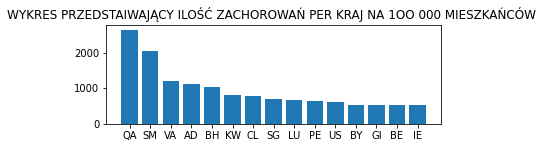

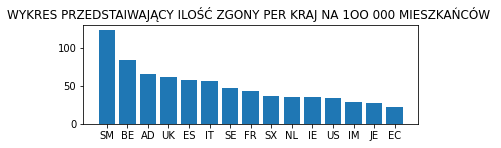

In [11]:
df1 = tab2.limit(15).toPandas()
df2 = tab3.limit(15).toPandas()
plt.subplot(2,1,1)
plt.bar(df1.geoId, df1.cases_per_100k_inhabitants)
plt.title("WYKRES PRZEDSTAIWAJĄCY ILOŚĆ ZACHOROWAŃ PER KRAJ NA 1OO 000 MIESZKAŃCÓW ")
plt.show()
plt.subplot(2,1,2)
plt.bar(df2.geoId, df2.deaths_per_100k_inhabitants)
plt.title("WYKRES PRZEDSTAIWAJĄCY ILOŚĆ ZGONY PER KRAJ NA 1OO 000 MIESZKAŃCÓW ")
plt.show()

In [12]:
### ANALIZA PORÓWNAWCZA - PORÓWNANIE ILOŚCI ZGONÓW W POLSCE I SZWAJCARII

tab_pl = spark.sql(
    "SELECT * \
     FROM dataset \
     WHERE geoId LIKE 'PL' \
     ORDER BY YEAR, MONTH, DAY "
    )
tab_pl.createOrReplaceTempView("tab_pl")

tab_ch = spark.sql(
    "SELECT * \
     FROM dataset \
     WHERE geoId LIKE 'CH' \
     ORDER BY YEAR, MONTH, DAY "
    )
tab_ch.createOrReplaceTempView("tab_ch")

tab_join = spark.sql(
    "SELECT DISTINCT tab_pl.dateRep,tab_pl.year, tab_pl.month, tab_pl.day, tab_ch.daily_deaths_per_100k_inhabitants AS daily_deaths_per_100k_inhabitants_in_Switzerland, tab_pl.daily_deaths_per_100k_inhabitants AS daily_deaths_per_100k_inhabitants_in_Poland \
     FROM tab_pl INNER JOIN tab_ch ON tab_pl.dateRep = tab_ch.dateRep \
     ORDER BY 2,3,4 "
    )
tab_join.createOrReplaceTempView("tab_join")
tab_join.show()

+----------+----+-----+---+------------------------------------------------+-------------------------------------------+
|   dateRep|year|month|day|daily_deaths_per_100k_inhabitants_in_Switzerland|daily_deaths_per_100k_inhabitants_in_Poland|
+----------+----+-----+---+------------------------------------------------+-------------------------------------------+
|04/03/2020|2020|    3|  4|                                             0.0|                                        0.0|
|07/03/2020|2020|    3|  7|                                             0.0|                                        0.0|
|08/03/2020|2020|    3|  8|                                             0.0|                                        0.0|
|09/03/2020|2020|    3|  9|                            0.011741853472706003|                                        0.0|
|10/03/2020|2020|    3| 10|                                             0.0|                                        0.0|
|11/03/2020|2020|    3| 11|     

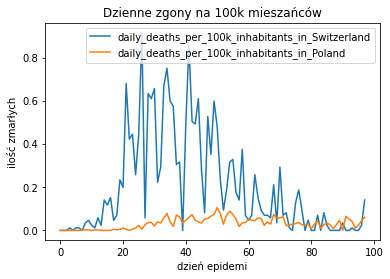

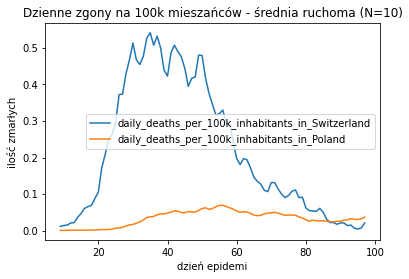

- Jak można wnioskować z wykresu Szajcarzy dużo dotkliwiej odczuli skutki epidemi. 
- W ostatnich 40 dniach epidemii można zauważyć stosunkowy spadek śmiertelnści na terenie Szwajcarii.   
- W polsce wskażnik ten jest  stabilny i utrzymuję się na stosunkowo niskim poziomie. 
- Można również zauważyć że w ciągu ostatnich 30 dni wkaźnik dla Polski i Szwajcarii utrzymuję się na zbliżonym poziomie.


In [13]:
df_join = tab_join.toPandas()
df_join.set_index('dateRep')
df_join.daily_deaths_per_100k_inhabitants_in_Switzerland.plot(title = "Dzienne zgony na 100k mieszańców", legend=True)
plt.xlabel('dzień epidemi')
plt.ylabel('ilość zmarłych')
df_join.daily_deaths_per_100k_inhabitants_in_Poland.plot(legend=True)

plt.show()

df_join = tab_join.toPandas()
df_join.daily_deaths_per_100k_inhabitants_in_Switzerland.rolling(window = 10).mean().plot(title = "Dzienne zgony na 100k mieszańców - średnia ruchoma (N=10)", legend=True)
plt.xlabel('dzień epidemi')
plt.ylabel('ilość zmarłych')
df_join.daily_deaths_per_100k_inhabitants_in_Poland.rolling(window = 10).mean().plot(legend=True)

plt.show()
print("- Jak można wnioskować z wykresu Szajcarzy dużo dotkliwiej odczuli skutki epidemi. \
\n- W ostatnich 40 dniach epidemii można zauważyć stosunkowy spadek śmiertelnści na terenie Szwajcarii.   \
\n- W polsce wskażnik ten jest  stabilny i utrzymuję się na stosunkowo niskim poziomie. \
\n- Można również zauważyć że w ciągu ostatnich 30 dni wkaźnik dla Polski i Szwajcarii utrzymuję się na zbliżonym poziomie." )

In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22302 entries, 0 to 22800
Data columns (total 11 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   dateRep                  22302 non-null  object 
 1   day                      22302 non-null  int64  
 2   month                    22302 non-null  int64  
 3   year                     22302 non-null  int64  
 4   cases                    22302 non-null  int64  
 5   deaths                   22302 non-null  int64  
 6   countriesAndTerritories  22302 non-null  object 
 7   geoId                    22302 non-null  object 
 8   countryterritoryCode     22302 non-null  object 
 9   popData2018              22302 non-null  float64
 10  continentExp             22302 non-null  object 
dtypes: float64(1), int64(5), object(5)
memory usage: 2.0+ MB


In [15]:
### ANALIZA PREDYKCYJNA - PROGNOZA SKUMULOWANEJ ILOŚĆ ZACHOROWAŃ NA TERENIE STANÓW ZJEDNOCZONYCH

tab_us = spark.sql(
    "SELECT * \
     FROM dataset \
     WHERE geoId LIKE 'US' \
     ORDER BY YEAR ASC, MONTH ASC, DAY ASC "
    )
tab_us.createOrReplaceTempView("tab_us")
tab_us.show(5)


+----------+---+-----+----+-----+------+-----------------------+-----+--------------------+------------+------------+--------------------------------+---------------------------------+
|   dateRep|day|month|year|cases|deaths|countriesAndTerritories|geoId|countryterritoryCode| popData2018|continentExp|daily_cases_per_100k_inhabitants|daily_deaths_per_100k_inhabitants|
+----------+---+-----+----+-----+------+-----------------------+-----+--------------------+------------+------------+--------------------------------+---------------------------------+
|31/12/2019| 31|   12|2019|    0|     0|   United_States_of_...|   US|                 USA|3.27167434E8|     America|                             0.0|                              0.0|
|01/01/2020|  1|    1|2020|    0|     0|   United_States_of_...|   US|                 USA|3.27167434E8|     America|                             0.0|                              0.0|
|02/01/2020|  2|    1|2020|    0|     0|   United_States_of_...|   US|     

In [16]:
import datetime
from datetime import date

today = date.today()
today_l = str(today).split("-")
today_year = int(today_l[0])
today_month = int(today_l[1])
today_day = int(today_l[2])

delta = datetime.timedelta(days=30)

today + delta

datetime.date(2020, 7, 11)

In [17]:
from pyspark.sql import Window
from pyspark.sql.functions import monotonically_increasing_id

tab_us = tab_us.withColumn('cumulative_cases', F.sum('cases').over(Window.rowsBetween(Window.unboundedPreceding, 0)))
tab_us = tab_us.filter(tab_us.cumulative_cases > 0)

tab_us = tab_us.withColumn("nr_of_the_pandemic_day", monotonically_increasing_id())
tab_us_model = tab_us.select(tab_us.nr_of_the_pandemic_day, tab_us.cumulative_cases)
nr_of_tomorrow_pandemic_day = tab_us_model.count()
tab_us_model = tab_us_model.orderBy(tab_us_model.cumulative_cases, ascending = False).limit(10)
tab_us_model.show(5)
print(nr_of_tomorrow_pandemic_day)

+----------------------+----------------+
|nr_of_the_pandemic_day|cumulative_cases|
+----------------------+----------------+
|                   142|         2000464|
|                   141|         1979850|
|                   140|         1961185|
|                   139|         1942363|
|                   138|         1920061|
+----------------------+----------------+
only showing top 5 rows

143


In [0]:
from pyspark.ml.feature import VectorAssembler
vectorAssembler = VectorAssembler(inputCols = ['nr_of_the_pandemic_day'], outputCol = 'features')
tab_us_model_trans = vectorAssembler.transform(tab_us_model)
tab_us_model_trans = tab_us_model_trans.select(['features', 'cumulative_cases'])

In [19]:
from pyspark.ml.regression import LinearRegression
lr = LinearRegression(featuresCol = 'features', labelCol='cumulative_cases')
lr_model = lr.fit(tab_us_model_trans)
print("Coefficients: " + str(lr_model.coefficients))
print("Intercept: " + str(lr_model.intercept))

Coefficients: [21324.503030306532]
Intercept: -1025215.2666671481


In [0]:
next_d = 5
df_len = nr_of_tomorrow_pandemic_day + next_d
freq = 1
test_set = spark.range(nr_of_tomorrow_pandemic_day, df_len, freq).toDF("next_{}_days".format(next_d))

vectorAssembler = VectorAssembler(inputCols = ["next_{}_days".format(next_d)], outputCol = 'features')
tab_us_forecast_trans = vectorAssembler.transform(test_set)

In [21]:
lr_predictions = lr_model.transform(tab_us_forecast_trans)
results = lr_predictions.withColumn("forecast", F.round(lr_predictions.prediction))
results = results.select([("next_{}_days".format(next_d)), results.forecast])
results.show()

+-----------+---------+
|next_5_days| forecast|
+-----------+---------+
|        143|2024189.0|
|        144|2045513.0|
|        145|2066838.0|
|        146|2088162.0|
|        147|2109487.0|
+-----------+---------+



In [0]:
df_future = results.toPandas()
df_past = tab_us.toPandas()

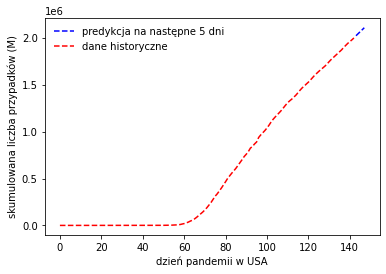

In [23]:
plt.plot(df_future["next_{}_days".format(next_d)], list(df_future.forecast),'--b', label = "predykcja na następne {} dni".format(next_d))
plt.plot(list(df_past.nr_of_the_pandemic_day), list(df_past.cumulative_cases),'--r', label = "dane historyczne")
plt.legend(loc='upper left', frameon=False)
plt.xlabel("dzień pandemii w USA")
plt.ylabel("skumulowana liczba przypadków (M)")
plt.show()

In [0]:
yesterday = list(df_past.cumulative_cases)[-2]
today = list(df_past.cumulative_cases)[-1]
tomorrow = list(df_future.forecast)[0]
the_day_after_tomorrow = list(df_future.forecast)[1]

In [25]:
print("Informacje na temat rozwoju pandemii w USA dla najbliższych 2 dni.\n")
pd.DataFrame({"dzień":["wczoraj", "dzisiaj", "jutro", "pojutrze"],"skumulowana_ilość_przypadków":[yesterday, today, tomorrow, the_day_after_tomorrow]} )


Informacje na temat rozwoju pandemii w USA dla najbliższych 2 dni.



,dzień,skumulowana_ilość_przypadków
0,wczoraj,1979850.0
1,dzisiaj,2000464.0
2,jutro,2024189.0
3,pojutrze,2045513.0
